## Example use of bbSelectPartitioning
**bbSelectPartitioning** is the package used to analyse the pharmacophore feature placement maps and has a number of useful functions

- This notebook shows how the overall occupancies can be visualised and details the objects used to perform partitioning
- The different classical and SOM partitioning methods are also exemplified, with the effect different parameters have on the partitioning
- The enamine carboxylic acid test set is used to exemplify these methods

In [1]:
import math
import random
import pandas as pd
import matplotlib as plt
import sys
sys.path.append('../')
import logging

#from minisom import MiniSom

## For visualisation
import matplotlib.colors as colors
import matplotlib.cm as cmx

#from bbSelectBuild import *
from bbSelectPartitioning import *
from bbSelect import *
np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=5000)

plt.rcParams['figure.figsize'] = [15,10]

In [2]:
## Load input database reference file. This contains the database settings which are needed for the clustering
input_ref = '../data/enamine_acids/enamine_acids_filtered_omega.ref'
inref = open(input_ref, 'r')
DBconfiguration = get_bbgap_configuration(inref)
inref.close()

### Initialisation of the bbSelectPartitioning object
The code requires the formation of a selection_maps object, which is simply initialised using parameters from the database. Importantly, the 'density_fp' paramater is the same length as the mGAP fingerprint, and contains counts at each position for how many times that bit is turned on in the database. This is all it needs to get started

In [3]:
## Initiate selection_maps object
densities = selection_maps(fp = DBconfiguration['density_fp'],
                            numX = DBconfiguration['numX'],
                            numY = DBconfiguration['numY'],
                            pharmacophore_dict = DBconfiguration['pharmacophores'],
                            excess_bits = DBconfiguration['excess_bits'])

### Setting a selection size

From here, a selection number can be set. The input for selection can vary as a number of selection methods have been written.

In [4]:
## Set the selection
densities.SetSelection(selection= 96)

## See what the selection from each pharmacophore will be
selection = densities.GetSelection()
selection_text = "Desired selection from each pharmacophore:\n"
for i in selection.keys():
    text = f'pharmacophore {i}: {selection[i]}\n'
    selection_text += text
print(selection_text)

Desired selection from each pharmacophore:
pharmacophore Donor: 16
pharmacophore Acceptor: 16
pharmacophore NegIonizable: 16
pharmacophore PosIonizable: 16
pharmacophore Aromatic: 16
pharmacophore Hydrophobe: 16



### Visualisation of the covered chemical space
Heatmaps can be generated from the densities for the fingerprints. These show how often the pharmacophore is positioned in the cell across the entire set.

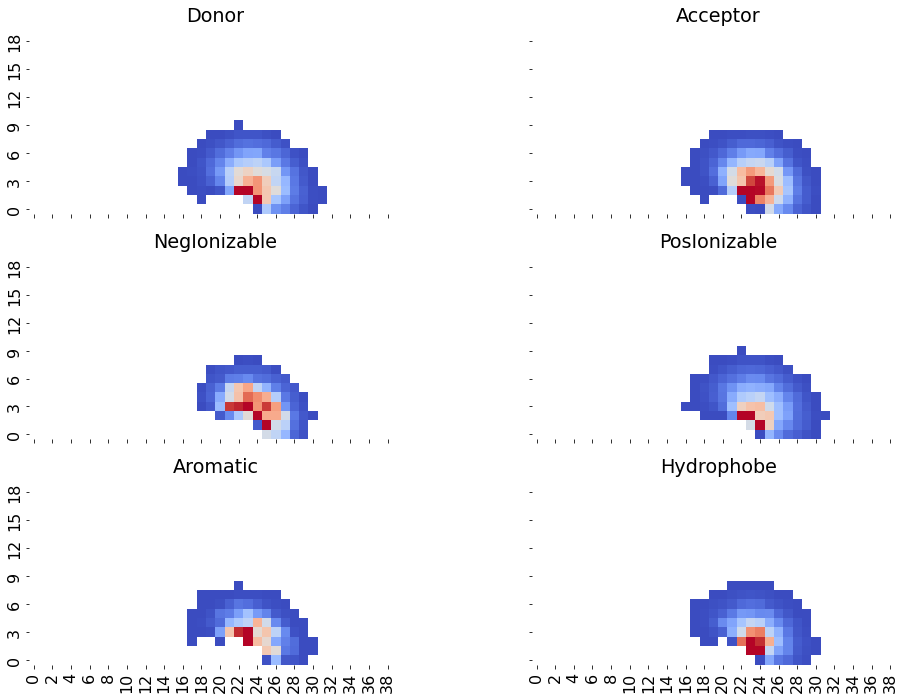

In [19]:
## Show the heatmaps for each of the pharmacophores
density_heatmaps = densities.density_heatmaps(trimmed = False, new_style = True, cmap = 'coolwarm', vmin = 1, linewidths = 0)

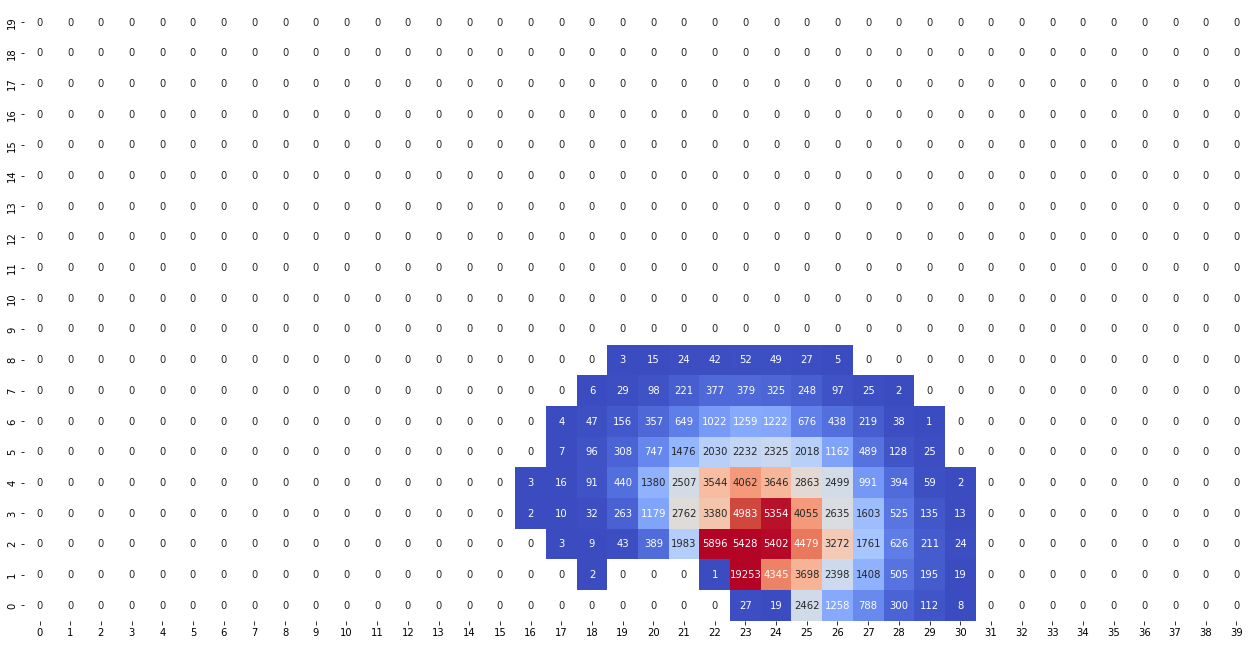

In [6]:
## Look specifically at a heatmap for a single pharmacophore, untrimmed
plt.rcParams['figure.figsize'] = [22,18]
densities.pharmacophore('Acceptor').density_heatmap(untrimmed = True, new_style = True)

In [7]:
# Show the map as a numpy array
#print(densities.pharmacophore('Acceptor')._untrimmed_density_map.astype(int))

Text(0.5, 1.0, 'Acceptor')

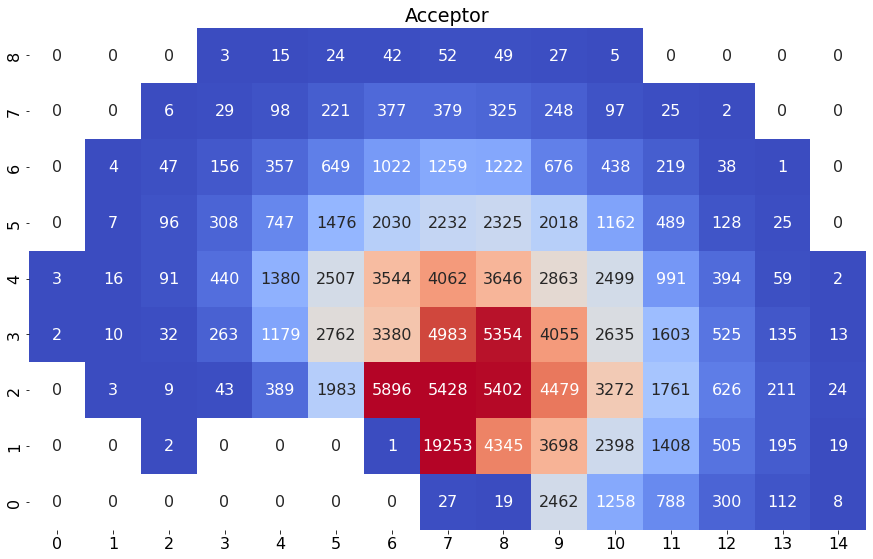

In [8]:
## Heatmap for 01_A (hydrogen bond acceptors)
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams.update({'font.size': 16})
densities.pharmacophore('Acceptor').density_heatmap(new_style = True)
plt.title('Acceptor')

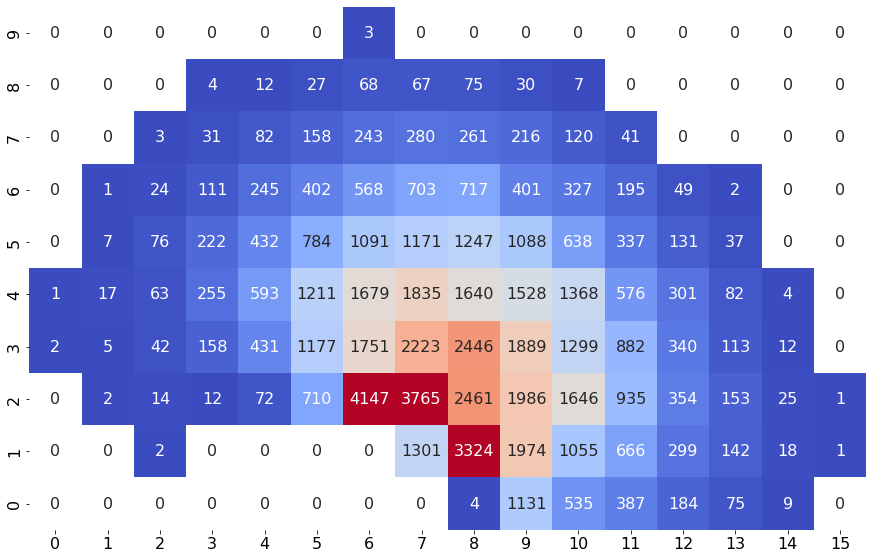

In [9]:
## Heatmap for 04_D (hydrogen bond donors)
densities.pharmacophore('Donor').density_heatmap()

## Create, train and visualise the SOM

 Here, the method converts the density heatmap into a scatter plot. The scatter plot is then used to train the SOM. 
- The weights for the neurons of the SOM are the x,y coordinates.
-  Each point in the scatter plot can be associated with its nearest neuron, giving clusters

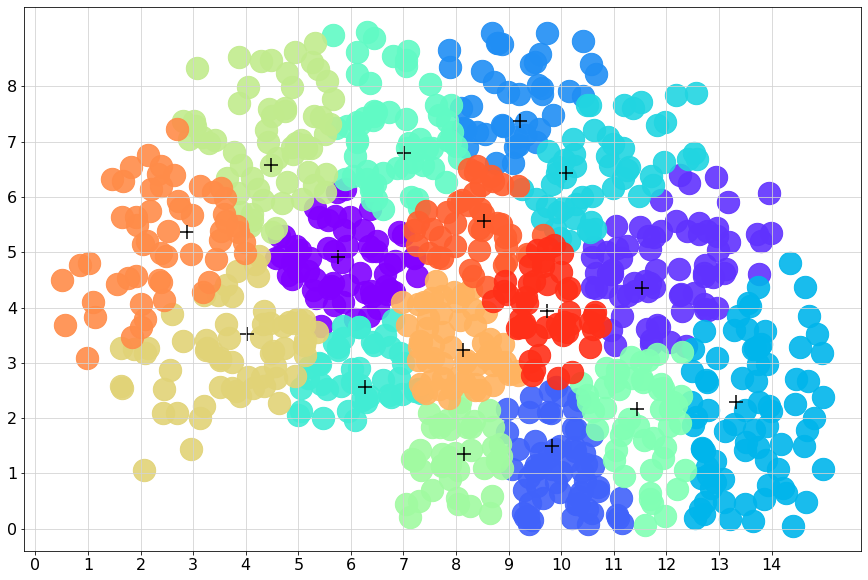

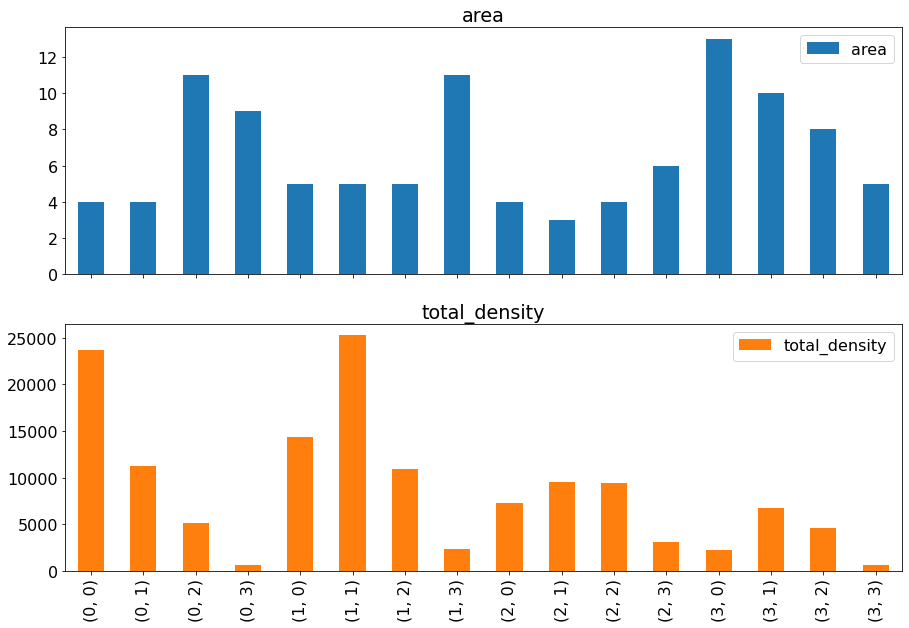

In [10]:
pharmacophore = 'Acceptor'

## Tran SOM using a log base 2 to transform the densities.

densities.pharmacophore(pharmacophore).som_partitioning(
    selection_size = 16,
    log = 2, 
    sigma = 1,
    multiplier = 1,
    learning_rate = 0.5, 
    num_iteration = 'len',
    neighborhood_function = 'gaussian',
    seed = 3,
    random_weights_init = False)

# Visualise SOM on scatter
densities.pharmacophore(pharmacophore).visualise_som()

# Visualise scatter plot
#densities.pharmacophore(pharmacophore).visualise_scatter()

# Analyse the clustering
_ = densities.pharmacophore(pharmacophore).analyse_SOM_partitions()

Each cell is then iterated to understand which neuron is should associate with.

This gives a cell-level clustering which can be converted to a fingerprint

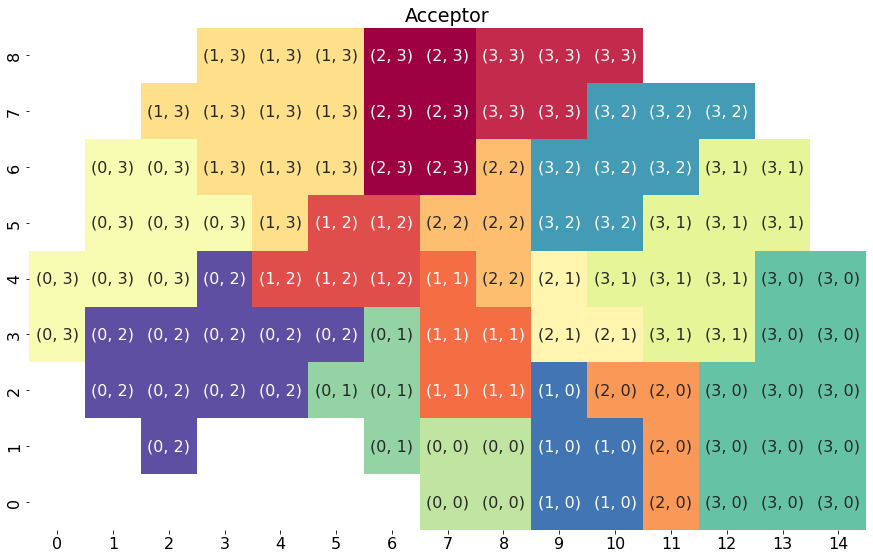

In [11]:
som_cluster_fig = densities.pharmacophore('Acceptor').visualise_SOM_partitions(annot_density = False, show_neurons = False, ax_alias = False)

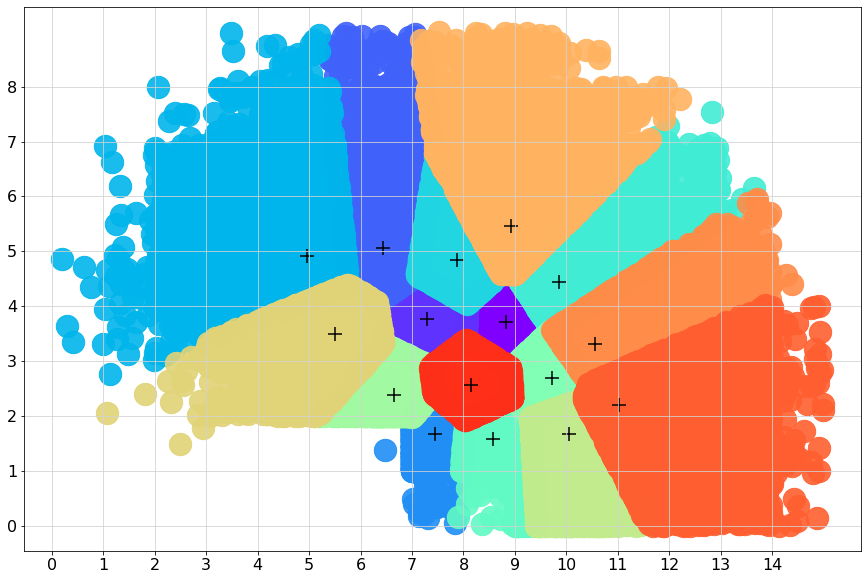

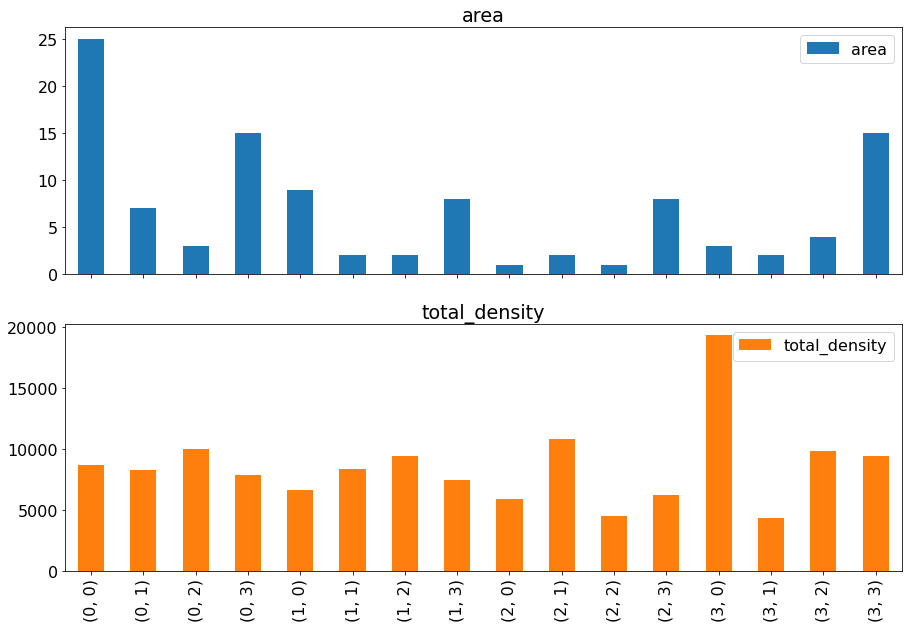

In [12]:
## This shows the same as above, without the use of log2 transformation.
## This results in most of the partitions coming from the centre of the distribution

pharmacophore = 'Acceptor'
densities.pharmacophore(pharmacophore).som_partitioning(
    selection_size = 16,
    log = None, 
    sigma = 1,
    multiplier = 1,
    learning_rate = 0.5, 
    num_iteration = 'len',
    neighborhood_function = 'gaussian',
    seed = 53,
    random_weights_init = False)
densities.pharmacophore(pharmacophore).visualise_som()
# Analyse distribution of clustering
cluster_df = densities.pharmacophore(pharmacophore).analyse_SOM_partitions()

## 0.5 sigma mexican hat with more iterations. below this it won't update other nodes

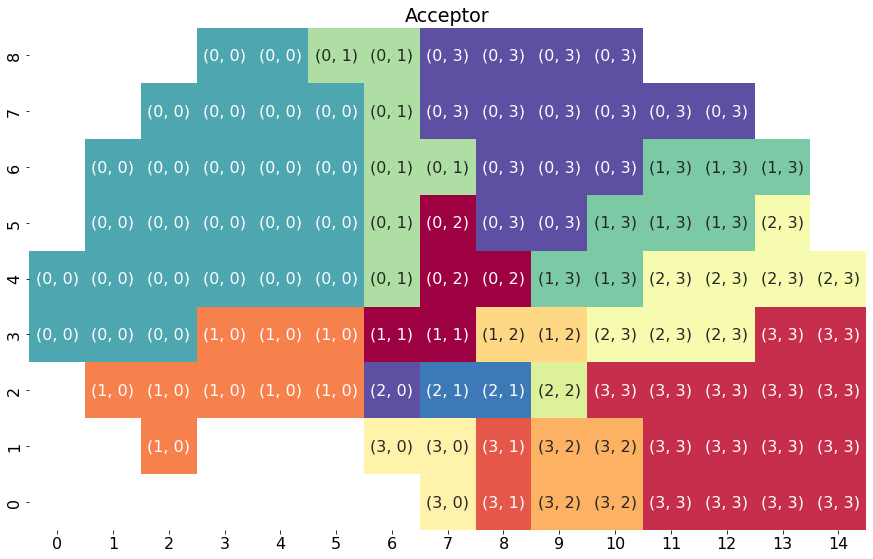

In [13]:
som_cluster_fig = densities.pharmacophore('Acceptor').visualise_SOM_partitions(annot_density = False, show_neurons = False, ax_alias = False)

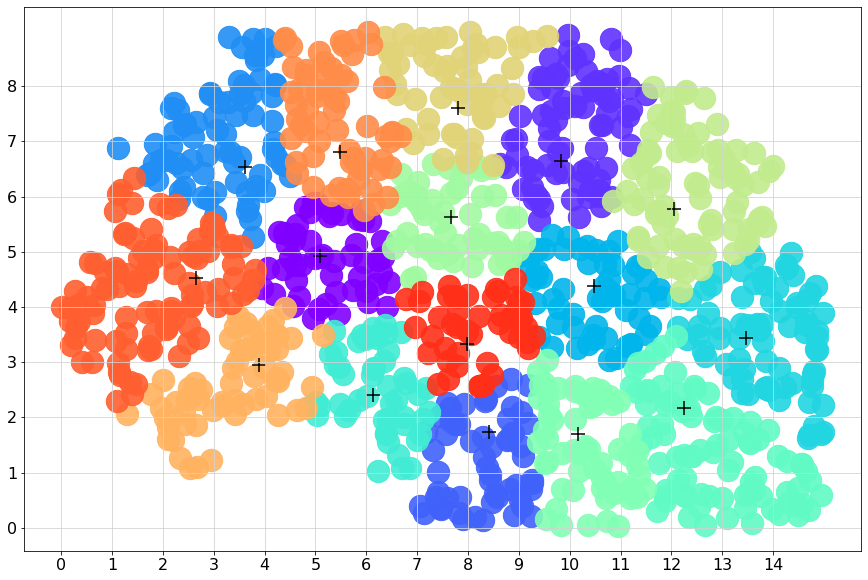

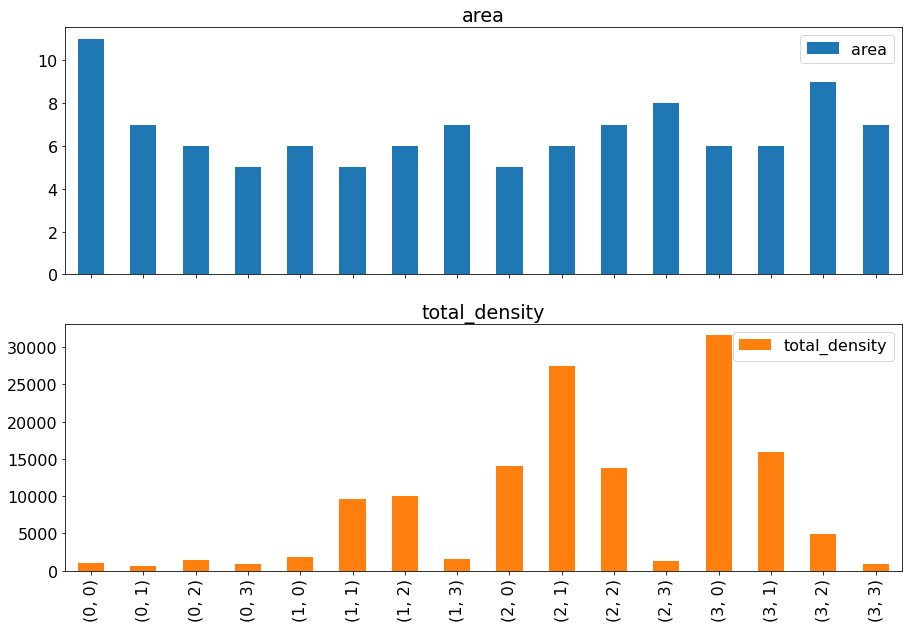

In [14]:
## This flattens the distribution to give an analogous partitioning to the classic partitioning.

## A multiplier can be used to boost the amount of data used to train the SOM

pharmacophore = 'Acceptor'

densities.pharmacophore(pharmacophore).som_partitioning(
    selection_size = 16,
    #log = None, 
    sigma = 1,
    multiplier = 10,
    learning_rate = 0.5, 
    num_iteration = 'len',
    neighborhood_function = 'gaussian',
    seed = 53,
    random_weights_init = False,
    transform_func = return_1)
densities.pharmacophore(pharmacophore).visualise_som()
# Analyse distribution of clustering
cluster_df = densities.pharmacophore(pharmacophore).analyse_SOM_partitions()

## 0.5 sigma mexican hat with more iterations. below this it won't update other nodes

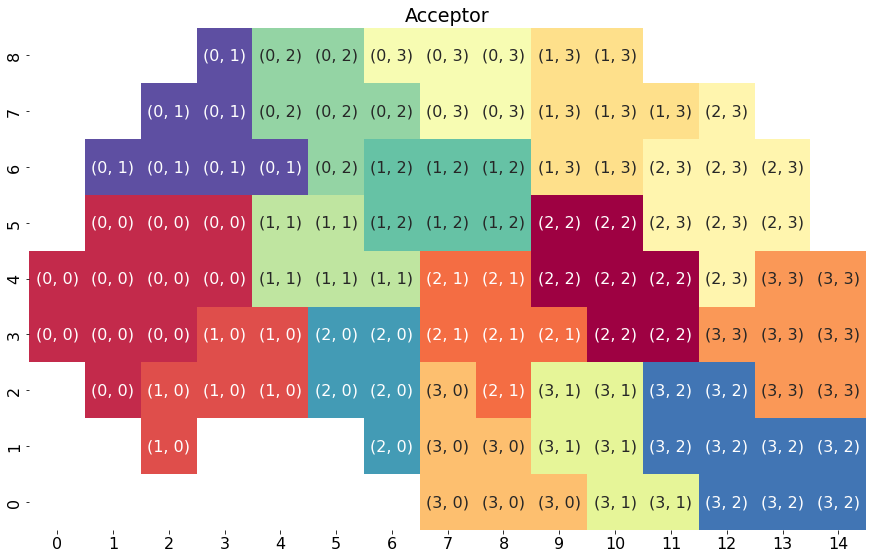

In [15]:
som_cluster_fig = densities.pharmacophore('Acceptor').visualise_SOM_partitions(annot_density = False, show_neurons = False, ax_alias = False)

## Classical partitioning.
The area can also be split in a more systematic and even way, based on the total space available
- This ensures that as many regions of the chemical space are covered
- In order to accomodate a wide range of selection sizes, the selection areas are permitted to vary slightly
- There is therefore a +- 1 cell allowance in x,y coordinates for sub-area dimensions.

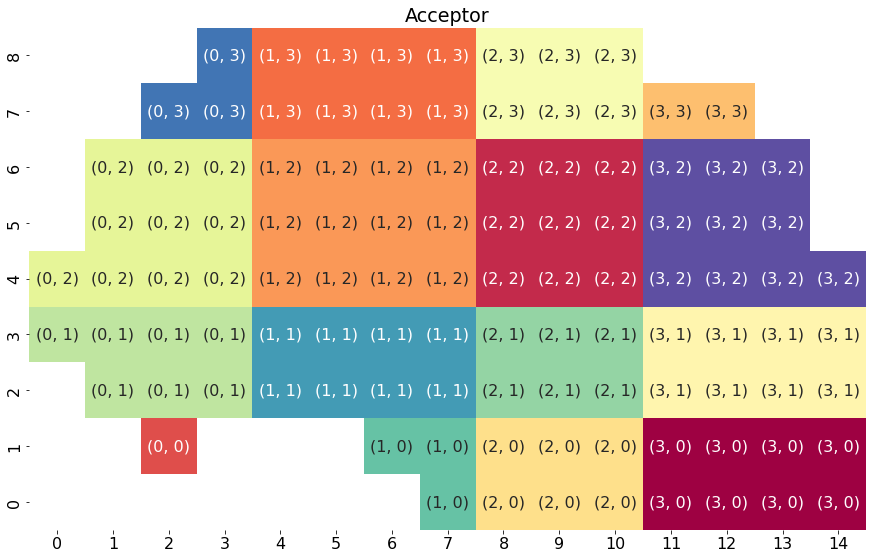

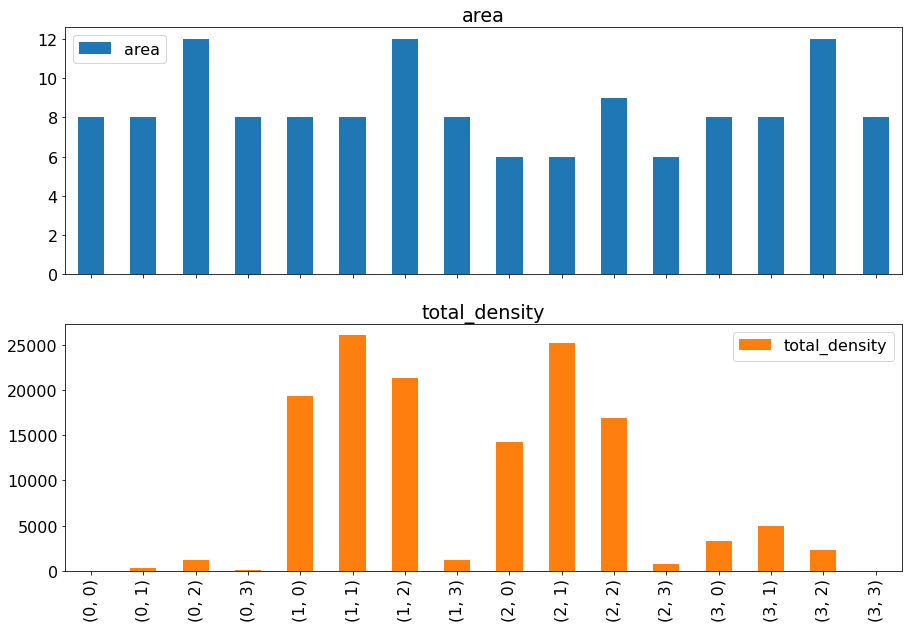

In [16]:
pharmacophore = 'Acceptor'

densities.pharmacophore(pharmacophore).classic_partitioning(
    selection_size = 16, 
    dimension_ratio = 0.4,
    method = 'floor')
densities.pharmacophore(pharmacophore).visualise_classic_partitions(annot_density = False)

# Analyse distribution of clustering
even_cluster_df = densities.pharmacophore(pharmacophore).analyse_classic_partitions()

## Final product
All of these steps can be performed automatically by giving the code:
- instructions for the selection size and which pharmacophores to select from using ```self.SetSelection(selection = selection_params)```
- instruction as to which clustering method to use, e.g. ```self.set_driven_clustering()``` or ```self.space_driven_clustering```

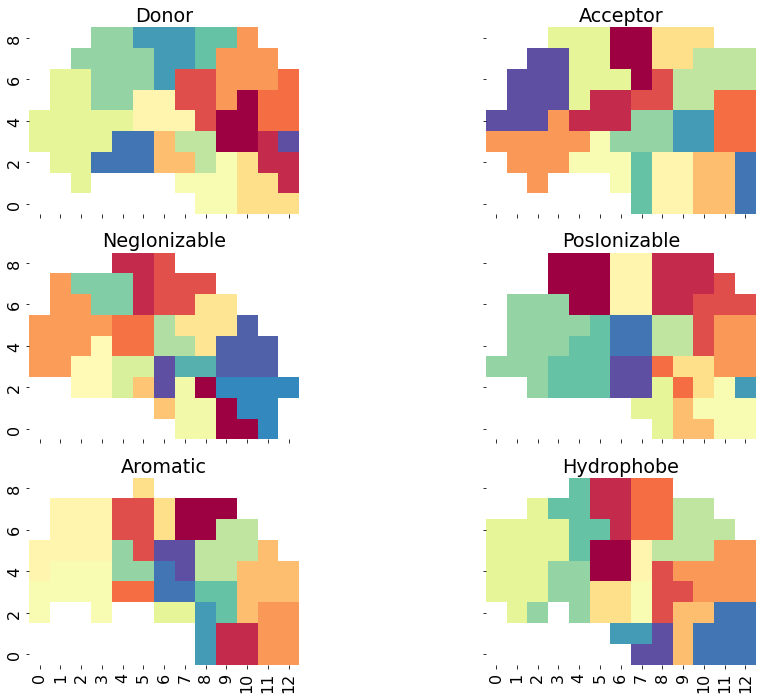

In [17]:
## This command instructs the code to perform the set-based clustering on the entire set
densities.SetSelection(selection = 96)
#densities.set_driven_clustering(sigma = 0.5)
densities.som_partitioning()
## Create a multi-plot showing how the selection has been performed
fig = densities.selection_partition_maps(untrimmed = False)
#fig.savefig('selection_map_figure.png')

In [18]:
## Compare collections
